# PredictionEnsemble Objects

One of the major features of `climpred` is our objects that are based upon the `PredictionEnsemble` class. We supply users with a `HindcastEnsemble` and `PerfectModelEnsemble` object. We encourage users to take advantage of these high-level objects, which wrap all of our core functions.

Briefly, we consider a `HindcastEnsemble` to be one that is initialized from some observational-like product (e.g., assimilated data, reanalysis products, or a model reconstruction). Thus, this object is built around comparing the initialized ensemble to various observational products. In contrast, a `PerfectModelEnsemble` is one that is initialized off of a model control simulation. These forecasting systems are not meant to be compared directly to real-world observations. Instead, they provide a contained model environment with which to theoretically study the limits of predictability. You can read more about the terminology used in `climpred` [here](terminology.html).

Let's create a demo object to explore some of the functionality and why they are much smoother to use than direct function calls.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from climpred import HindcastEnsemble, PerfectModelEnsemble
from climpred.tutorial import load_dataset
import climpred

xr.set_options(display_style='text')

We can now pull in some sample data that is packaged with `climpred`.

## HindcastEnsemble

We'll start out with a `HindcastEnsemble` demo, followed by a `PerfectModelEnsemble` case.

In [2]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST') # CESM-DPLE hindcast ensemble output.
obs = climpred.tutorial.load_dataset('ERSST') # ERSST observations.

We need to add a "units" attribute to the hindcast ensemble so that `climpred` knows how to interpret the lead units.

In [3]:
hind["lead"].attrs["units"] = "years"

Now we instantiate the `HindcastEnsemble` object and append all of our products to it.

In [4]:
hindcast = HindcastEnsemble(hind) # Instantiate object by passing in our initialized ensemble.
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 ...
Observations:
    None
Uninitialized:
    None


/Users/aaron.spring/Coding/climpred/climpred/utils.py:140: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


Now we just use the `add_` methods to attach other objects. See the API [here](api.html#add-and-retrieve-datasets). **Note that we strive to make our conventions follow those of `xarray`'s**. For example, we don't allow inplace operations. One has to run `hindcast = hindcast.add_observations(...)` to modify the object upon later calls rather than just `hindcast.add_observations(...)`.

In [5]:
hindcast = hindcast.add_observations(obs)
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 ...
Observations:
    SST      (time) float32 ...
Uninitialized:
    None


You can apply most standard `xarray` functions directly to our objects! `climpred` will loop through the objects and apply the function to all applicable `xarray.Datasets` within the object. If you reference a dimension that doesn't exist for the given `xarray.Dataset`, it will ignore it. This is useful, since the initialized ensemble is expected to have dimension `init`, while other products have dimension `time` (see more [here](setting-up-data.html)).

Let's start by taking the ensemble mean of the initialized ensemble so our metric computations don't have to take the extra time on that later. Just using deterministic metrics here, so we don't need the individual ensemble members. Note that above our initialized ensemble had a `member` dimension, and now it is reduced. Those `xarray` functions do not raise errors such as `ValueError`, `KeyError`, `DimensionError`, but show respective warnings, which can be filtered away with `warnings.filterwarnings("ignore")`.

In [6]:
hindcast = hindcast.mean('member')
hindcast

/Users/aaron.spring/Coding/climpred/climpred/classes.py:378: UserWarning: Error due to verification/control/uninitialized: xr.mean(('member',), {}) failed
ValueError: Dataset does not contain the dimensions: ['member']
  warnings.warn(


<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead) float64 -0.2121 -0.1637 -0.1206 ... 0.7286 0.7532
Observations:
    SST      (time) float32 ...
Uninitialized:
    None

### Arithmetic Operations with PredictionEnsemble Objects

`PredictionEnsemble` objects support arithmetic operations, i.e., `+`, `-`, `/`, `*`. You can perform these operations on a `HindcastEnsemble` or `PerfectModelEnsemble` by pairing the operation with an `int`, `float`, `np.ndarray`, `xr.DataArray`, `xr.Dataset`, or with another `PredictionEnsemble` object.

An obvious application would be to area-weight an initialized ensemble and all of its associated datasets (like verification products) simultaneously.

In [7]:
dple3d = climpred.tutorial.load_dataset('CESM-DP-SST-3D')
verif3d = climpred.tutorial.load_dataset('FOSI-SST-3D')
area = dple3d['TAREA']

Here, we load in a subset of CESM-DPLE over the eastern tropical Pacific. The file includes `TAREA`, which describes the area of each cell on the curvilinear mesh.

In [8]:
hindcast3d = HindcastEnsemble(dple3d)
hindcast3d = hindcast3d.add_observations(verif3d)
hindcast3d

/Users/aaron.spring/Coding/climpred/climpred/utils.py:140: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, nlat, nlon) float32 ...
Observations:
    SST      (time, nlat, nlon) float32 ...
Uninitialized:
    None

Now we can perform an area-weighting operation with the `HindcastEnsemble` object and the area `DataArray`. `climpred` cycles through all of the datasets appended to the `HindcastEnsemble` and applies them. You can see below that the dimensionality is reduced to single time series without spatial information.

In [9]:
hindcast3d_aw = (hindcast3d*area).sum(['nlat', 'nlon']) / area.sum(['nlat', 'nlon'])
hindcast3d_aw

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead) float64 -0.3539 0.1947 0.3623 ... 0.662 1.016 1.249
Observations:
    SST      (time) float64 24.76 24.48 23.73 24.68 ... 24.78 24.21 24.92 25.95
Uninitialized:
    None

**NOTE**: Be careful with the arithmetic operations. Some of the behavior can be unexpected in combination with the fact that generic `xarray` methods can be applied to `climpred` objects. For instance, one might be interested in removing a climatology from the verification data to move it to anomaly space. It's safest to do anything like climatology removal before constructing `climpred` objects.

Naturally, they would remove some climatology time slice as we do here below. However, note that in the below example, the intialized ensemble returns all zeroes for `SST`. The reasoning here is that when `hindcast.sel(time=...)` is called, `climpred` only applies that slicing to datasets that include the `time` dimension. Thus, it skips the initialized ensemble and returns the original dataset untouched. This feature is advantageous for cases like `hindcast.mean('member')`, where it takes the ensemble mean in all cases that ensemble members exist. So when it performs `hindcast - hindcast.sel(time=...)`, it subtracts the identical initialized ensemble from itself returning all zeroes. We are hoping to implement a fix to this issue in the future.

In short, any sort of bias correcting or drift correction should be done _prior_ to instantiating a `PredictionEnsemble` object. Alternatively, detrending or removing a mean state can also be done _after_ instantiating a `PredictionEnsemble` object. But beware of unintuitive behaviour. Removing a `time` anomaly in `PredictionEnsemble`, does not modify `initialized` and therefore returns all `0`s.

In [10]:
hindcast3d - hindcast3d.sel(time=slice('1960', '2014')).mean('time')

/Users/aaron.spring/Coding/climpred/climpred/classes.py:373: UserWarning: Error due to initialized:  xr.sel((), {'time': slice('1960', '2014', None)}) failed
ValueError: dimensions or multi-index levels ['time'] do not exist
  warnings.warn(f"Error due to initialized:  {msg}")
/Users/aaron.spring/Coding/climpred/climpred/classes.py:373: UserWarning: Error due to initialized:  xr.mean(('time',), {}) failed
ValueError: Dataset does not contain the dimensions: ['time']
  warnings.warn(f"Error due to initialized:  {msg}")


<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, nlat, nlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Observations:
    SST      (time, nlat, nlon) float32 0.01611 0.01459 0.0161 ... 1.543 1.49
Uninitialized:
    None

To fix this always handle all `PredictionEnsemble` datasets `initialized` with dimensions `lead` or `init` and `observations/control` with dimension `time` at the same time to avoid these zeros.

In [11]:
hindcast - hindcast.sel(time=slice('1960', '2014')).mean('time').sel(init=slice('1960', '2014')).mean('init')

/Users/aaron.spring/Coding/climpred/climpred/classes.py:373: UserWarning: Error due to initialized:  xr.sel((), {'time': slice('1960', '2014', None)}) failed
ValueError: dimensions or multi-index levels ['time'] do not exist
  warnings.warn(f"Error due to initialized:  {msg}")
/Users/aaron.spring/Coding/climpred/climpred/classes.py:373: UserWarning: Error due to initialized:  xr.mean(('time',), {}) failed
ValueError: Dataset does not contain the dimensions: ['time']
  warnings.warn(f"Error due to initialized:  {msg}")
/Users/aaron.spring/Coding/climpred/climpred/classes.py:382: UserWarning: xr.sel((), {'init': slice('1960', '2014', None)}) failed
ValueError: dimensions or multi-index levels ['init'] do not exist
  warnings.warn(msg)
/Users/aaron.spring/Coding/climpred/climpred/classes.py:382: UserWarning: xr.mean(('init',), {}) failed
ValueError: Dataset does not contain the dimensions: ['init']
  warnings.warn(msg)


<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead) float64 -0.2046 -0.1688 -0.1335 ... 0.6326 0.6463
Observations:
    SST      (time) float32 -0.3864 -0.3373 -0.17 ... 0.2632 0.3611 0.4653
Uninitialized:
    None

Note: Thinking in initialization space is not very intuitive and such combined `init` and `time` operations can lead to unanticipated changes in the `PredictionEnsemble`. The safest way is subtracting means before instantiating `PredictionEnsemble` or use `HindcastEnsemble.remove_bias()`.

### PredictionEnsemble.plot()

`PredictionEnsemble` also have a default `.plot()` call showing all datasets associated.

<AxesSubplot:xlabel='time', ylabel='SST'>

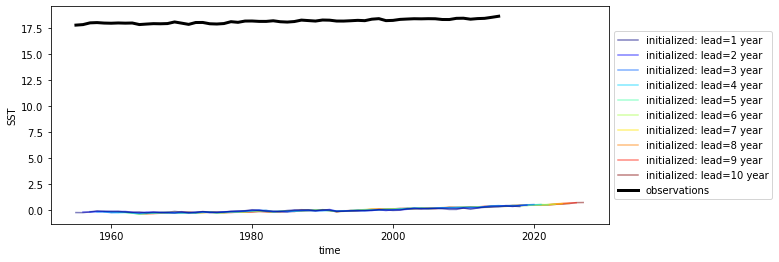

In [12]:
hindcast.plot()

We have a huge bias because the initialized data is already converted to an anomaly, but uninitialized historical and observations is not.

<AxesSubplot:xlabel='time', ylabel='SST'>

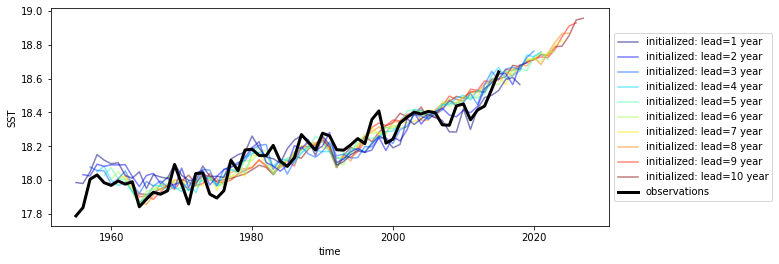

In [13]:
hindcast.remove_bias(alignment='same_verif').plot()

We still have a trend in all of our products, so we could also detrend them as well.

### Detrend

Here we use a kitchen sink package called `esmtools`. It has a few vectorized stats functions that are `dask`-friendly.

We can leverage `xarray`'s `.map()` function to apply/map a function to all variables in our datasets.

<AxesSubplot:xlabel='time', ylabel='SST'>

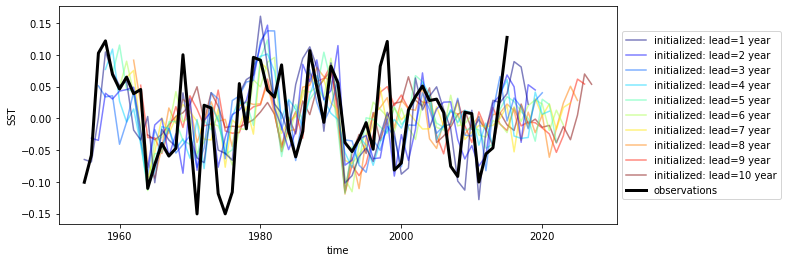

In [14]:
from esmtools.stats import rm_poly

hindcast_detrended = hindcast.map(rm_poly, order=2, dim='init_or_time')
hindcast_detrended.plot()

And it looks like everything got detrended by a quadratic fit! That wasn't too hard.

### Verify

Now that we've done our pre-processing, let's quickly compute some metrics. Check the metrics page [here](metrics.html) for all the keywords you can use. The [API](api.html#analysis-functions) is currently pretty simple for the `HindcastEnsemble`. You can essentially compute standard skill metrics and a reference persistence forecast.

In [15]:
hindcast_detrended.verify(metric='mse',
                          comparison='e2o',
                          dim='init',
                          alignment='same_verif',
                          reference='persistence')

<xarray.Dataset>
Dimensions:  (lead: 10, skill: 2)
Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
  * skill    (skill) <U11 'initialized' 'persistence'
Data variables:
    SST      (skill, lead) float64 0.003274 0.004149 ... 0.01109 0.008786

Here we leverage `xarray`'s plotting method to compute Mean Absolute Error and the Anomaly Correlation Coefficient against the ERSST observations, as well as the equivalent metrics computed for persistence forecasts for each of those metrics.

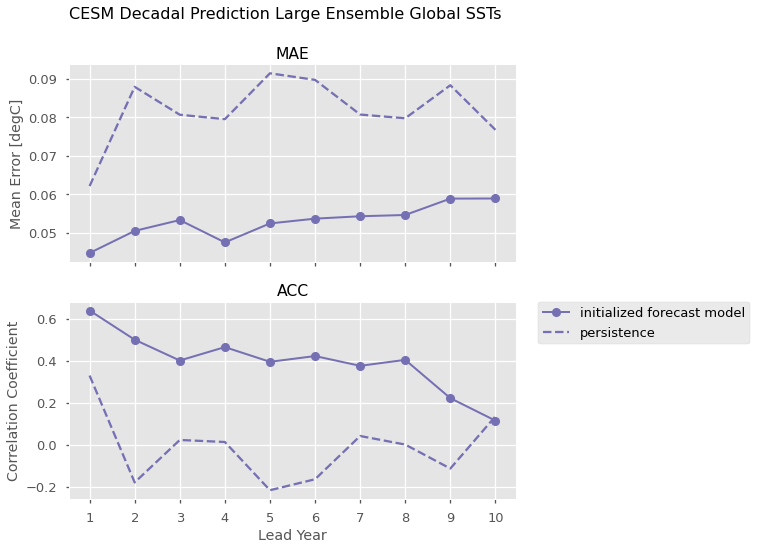

In [16]:
plt.style.use('ggplot')
plt.style.use('seaborn-talk')

color = '#7570b3'

f, axs = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)

for ax, metric in zip(axs.ravel(), ['mae', 'acc']):
    handles = []
    result = hindcast_detrended.verify(metric=metric, comparison='e2o', dim='init',
                                 alignment='same_verif',reference='persistence')
    p1, = result.sel(skill='initialized').SST.plot(ax=ax, 
                                       marker='o', 
                                       color=color,
                                       label='initialized forecast model',
                                       linewidth=2)
    p2, = result.sel(skill='persistence').SST.plot(ax=ax,
                                             color=color,
                                             linestyle='--',
                                             label='persistence')
    handles.append(p1)
    handles.append(p2)
    ax.set_title(metric.upper())
    

axs[0].set_ylabel('Mean Error [degC]')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_xlabel('')
axs[1].set_xlabel('Lead Year')
axs[1].set_xticks(np.arange(10)+1)

# matplotlib/xarray returning weirdness for the legend handles.
handles = [i.get_label() for i in handles]

# a little trick to put the legend on the outside.
plt.legend(handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.suptitle('CESM Decadal Prediction Large Ensemble Global SSTs', fontsize=16)
plt.show()

## PerfectModelEnsemble

We'll now play around a bit with the `PerfectModelEnsemble` object, using sample data from the MPI perfect model configuration.

In [17]:
ds = load_dataset('MPI-PM-DP-1D') # initialized ensemble from MPI
control = load_dataset('MPI-control-1D') # base control run that initialized it

ds["lead"].attrs["units"] = "years"

print(ds)

<xarray.Dataset>
Dimensions:  (area: 3, init: 12, lead: 20, member: 10, period: 5)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * period   (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
  * area     (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
  * init     (init) int64 3014 3023 3045 3061 3124 ... 3175 3178 3228 3237 3257
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    tos      (period, lead, area, init, member) float32 ...
    sos      (period, lead, area, init, member) float32 ...
    AMO      (period, lead, area, init, member) float32 ...


In [18]:
pm = climpred.PerfectModelEnsemble(ds)
pm = pm.add_control(control)
print(pm)

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (period, lead, area, init, member) float32 ...
    sos      (period, lead, area, init, member) float32 ...
    AMO      (period, lead, area, init, member) float32 ...
Control:
    tos      (period, time, area) float32 ...
    sos      (period, time, area) float32 ...
    AMO      (period, time, area) float32 ...
Uninitialized:
    None


/Users/aaron.spring/Coding/climpred/climpred/utils.py:140: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


Our objects are carrying sea surface temperature (`tos`), sea surface salinity (`sos`), and the Atlantic Multidecadal Oscillation index (`AMO`). Say we just want to look at skill metrics for temperature and salinity over the North Atlantic in JJA. We can just call a few easy `xarray` commands to filter down our object.

In [19]:
pm = pm[['tos', 'sos']].sel(area='North_Atlantic', period='JJA', drop=True)

Now we can easily compute for a host of metrics. Here I just show a number of deterministic skill metrics comparing all individual members to the initialized ensemble mean. See [comparisons](comparisons.html) for more information on the `comparison` keyword.

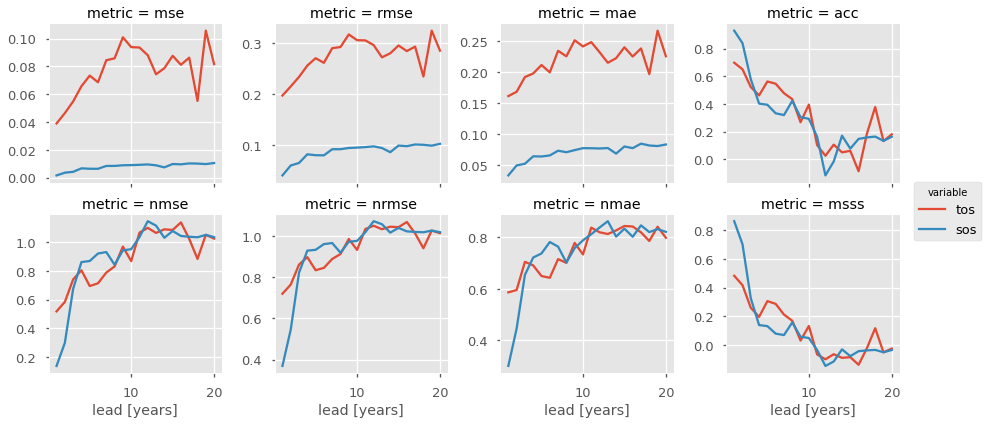

In [20]:
METRICS = ['mse', 'rmse', 'mae', 'acc',
           'nmse', 'nrmse', 'nmae', 'msss']

result = []
for metric in METRICS:
    result.append(pm.verify(metric=metric, comparison='m2e', dim=['init','member']))
    
result = xr.concat(result, 'metric')
result['metric'] = METRICS

# Leverage the `xarray` plotting wrapper to plot all results at once.
result.to_array().plot(col='metric', 
                       hue='variable', 
                       col_wrap=4, 
                       sharey=False, 
                       sharex=True)

It is useful to compare the initialized ensemble to an uninitialized run. See [terminology](terminology.html) for a description on "uninitialized" simulations. This gives us information about how *initializations* lead to enhanced predictability over knowledge of external forcing, whereas a comparison to persistence just tells us how well a dynamical forecast simulation does in comparison to a naive method. We can use the `generate_uninitialized()` method to bootstrap the control run and create a pseudo-ensemble that approximates what an uninitialized ensemble would look like.

In [21]:
pm = pm.generate_uninitialized()
pm

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (lead, init, member) float32 13.46 13.64 13.72 ... 13.55 13.57
    sos      (lead, init, member) float32 33.18 33.15 33.05 ... 33.18 33.26
Control:
    tos      (time) float32 13.5 13.74 13.78 13.86 ... 13.12 12.92 13.08 13.47
    sos      (time) float32 33.23 33.19 33.2 33.21 ... 33.15 33.22 33.16 33.18
Uninitialized:
    tos      (lead, init, member) float32 13.45 12.74 13.12 ... 13.65 13.38
    sos      (lead, init, member) float32 33.29 33.3 33.19 ... 33.36 33.24 33.24

In [22]:
pm = pm[['sos']] # Just assess for salinity.

Here we plot the ACC for the initialized, uninitialized, and persistence forecasts for North Atlantic sea surface salinity in JJA. We add circles to the lines if the correlations are statistically significant for $p <= 0.05$.

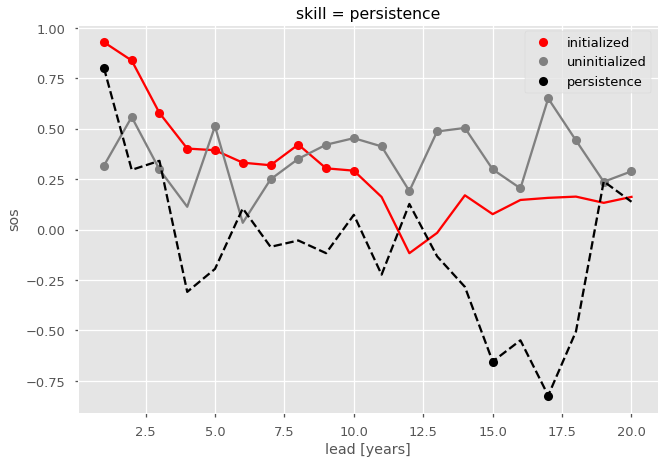

In [23]:
def plot_result(acc, pval, skill, color, label, linestyle='-'):
    """Helper function for cleaner plotting code."""
    acc.sel(skill=skill)['sos'].plot(color=color, linestyle=linestyle)
    masked_acc = acc.sel(skill=skill)['sos'].where(pval.sel(skill=skill)['sos'] <= 0.05)
    masked_acc.plot(marker='o', linestyle='None', color=color, label=label)

acc_result = pm.verify(metric='acc', comparison='m2e', dim=['init', 'member'] ,reference=['persistence', 'uninitialized'])
pval_result = pm.verify(metric='p_pval', comparison='m2e', dim=['init', 'member'], reference=['persistence', 'uninitialized'])

# ACC for initialized ensemble
plot_result(acc_result, pval_result, 'initialized', 'red', 'initialized')
plot_result(acc_result, pval_result, 'uninitialized', 'gray', 'uninitialized')
plot_result(acc_result, pval_result, 'persistence', 'black', 'persistence', linestyle='--')

plt.legend()